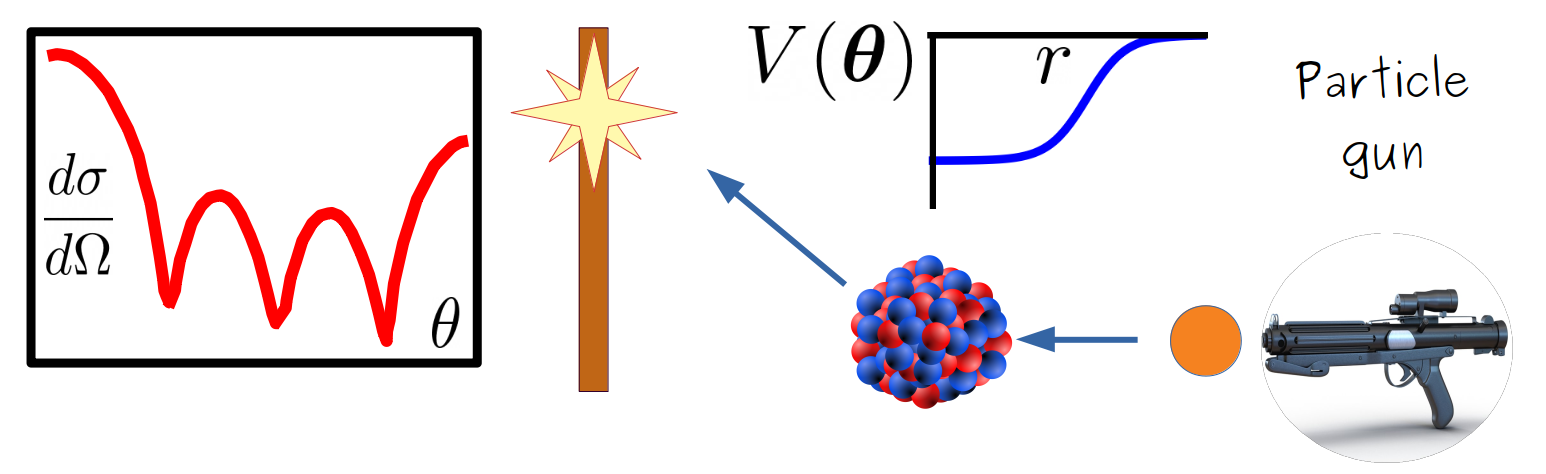

In [1]:
from IPython.display import Image
Image("bandframework/software/Bfrescox/Tutorial_I/frescox.png")

In [2]:
import os
import subprocess
import matplotlib.pyplot as plt

import scipy.stats as sps
from scipy import stats
import numpy as np
import pandas as pd
import pkg_resources
#pkg_resources.require("seaborn==0.11.0")
import seaborn as sns
import pylab
import random
from scipy.stats import qmc

In [3]:
# import os
# import subprocess
# import matplotlib.pyplot as plt

# commands = '''
#   export PATH=$PATH: ~/fewbody/Frescoxex/
#   cd bandframework/software/Bfrescox/Tutorial_I/python_scripts
#   mkdir frescox_outputs
#   frescox < frescox_inputs/D1048cadp.in > frescox_outputs/D1048cadp.out
#   frescox < frescox_inputs/LH1048cadp.in > frescox_outputs/LH1048cadp.out
# '''
# bashresults = subprocess.run(commands, capture_output=True, shell=True)

In [4]:

commands = '''
  cd bandframework/software/Bfrescox/Tutorial_I/python_scripts
  mkdir frescox_outputs
  mkdir fort_files
  ~/fewbody/Frescoxex/frescox < frescox_inputs/D1048cadp.in > frescox_outputs/D1048cadp.out
  cp fort.16 fort_files/40Ca_dxs
  ~/fewbody/Frescoxex/frescox < frescox_inputs/LH1048cadp.in > frescox_outputs/LH1048cadp.out
  cp fort.16 fort_files/40Ca_dxs_2
'''
bashresults = subprocess.run(commands, capture_output=True, shell=True)

In [5]:
os.chdir("bandframework/software/Bfrescox/Tutorial_I/python_scripts")
files = ['frescox_outputs/LH1048cadp.out', 'frescox_outputs/D1048cadp.out']
outs = []
for file in files:
    with open(file) as f:
        content = f.readlines()
        outs.append(content)

In [10]:
Rlist, slist = [], []
for out in outs:
    Rutherford = [] 
    sigma_omega_ratio = [] 
    for idline, line in enumerate(out):
        if '/R' in line:
            Rutherford.append(float(line.split()[3]))
        if (idline > 575) and ('X-S' in line):
            sigma_omega_ratio.append(float(line.split()[4]))
    
    Rlist.append(Rutherford)
    slist.append(sigma_omega_ratio)

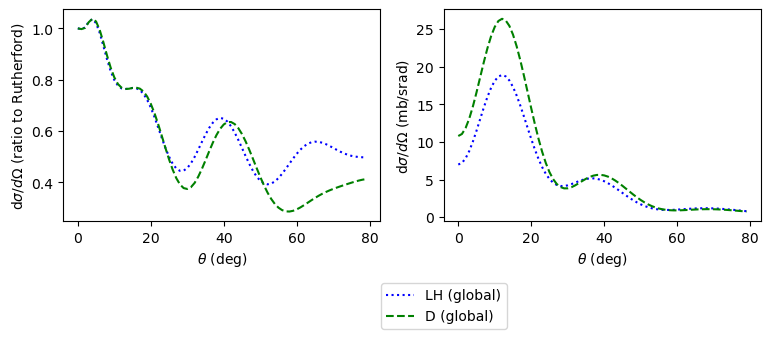

In [11]:
i = 0
fig, axes = plt.subplots(1, 2, figsize=(9,4))
for values in [Rlist, slist]:
    axes[i].plot(values[0][0:80], linestyle='dotted', c='blue', label='LH (global)')
    axes[i].plot(values[1][0:80], linestyle='dashed', c='green', label='D (global)')
    i += 1
fig.subplots_adjust(bottom=0.35)
plt.legend(bbox_to_anchor=(0, -0.4), loc='center')
axes[0].set_xlabel(r'$\theta$ (deg)')
axes[0].set_ylabel(r'd$\sigma/d\Omega$ (ratio to Rutherford)')
axes[1].set_xlabel(r'$\theta$ (deg)')
axes[1].set_ylabel(r'd$\sigma/d\Omega$ (mb/srad)')
plt.show()

In [12]:
def generate_input_file(parameter_values):
    #os.chdir("bandframework/software/Bfrescox/Tutorial_I/python_scripts")
    file = 'frescox_inputs/48Ca_template.in'

    with open(file) as f:
        content = f.readlines()
        
    no_p = 0;
    for idx, line in enumerate(content):
        if 'XXXXX' in line:
            no_param = line.count('XXXXX')
            line_temp = line
            for i in range(no_param):
                line_temp = line_temp.replace("XXXXX", str(parameter_values[no_p]), 1) 
                no_p += 1
    
            content[idx] = line_temp
    
    f = open("frescox_inputs/frescox_temp_input.in", "a")
    f.writelines(content)
    f.close()       

In [13]:
def frescox_output(input_file='frescox_inputs/frescox_temp_input.in',
                   output_file='frescox_outputs/48Ca_temp.out'):

    commands = '''
      cd ~/fewbody/bandframework/software/Bfrescox/Tutorial_I/python_scripts
      mkdir frescox_outputs
      ~/fewbody/Frescoxex/frescox < frescox_inputs/frescox_temp_input.in > frescox_outputs/48Ca_temp.out
    '''

    # Execute frescox
    bashresults = subprocess.run(commands, capture_output=True, shell=True)

    # Read outputs
    #os.chdir("bandframework/software/Bfrescox/Tutorial_I/python_scripts")

    with open(output_file) as f:
        content = f.readlines()
        
    sigma_omega_ratio = [] 
    for idline, line in enumerate(content):
        if ('X-S' in line):
            sigma_omega_ratio.append(float(line.split()[4]))
        
    os.remove(input_file)
    os.remove(output_file)
    
    return sigma_omega_ratio

In [14]:
def frescox_run(theta):
    theta_list = theta.tolist()
    f_l = []
    for para_obs in theta_list:
        para_obs += [3.5,1,0.3]
        generate_input_file(para_obs)
        exp_output = frescox_output()
        f_l.append(exp_output)

    return np.asarray(f_l).T

In [10]:
def latin_sampling_3(samples):
    
    '''Given a number of samples, generate a training array.'''
    
    #n_train = 50
    
    random.seed(142857)

    
    Vv0 = 51.8

    Rv0 = 1.17

    av0 = 0.75
    
    ## Central value of parameter values
    alphaCentral = np.array([Vv0, Rv0, av0])


    #Creating a scale for how much the parameters will wiggle. Afterwards we sample from a latin hyper cube for training,
    #but use this scales also for the testing sampling which we do it with a Gaussian
    scaleTraining=0.3

    bounds_Vv_Scale = abs(Vv0*(scaleTraining))

    bounds_Rv_Scale = abs(Rv0*(scaleTraining))

    bounds_av_Scale = abs(av0*(scaleTraining))

    bounds_alpha=[bounds_Vv_Scale,bounds_Rv_Scale,bounds_av_Scale]
    
    bounds_Vv = [Vv0-bounds_Vv_Scale, Vv0+bounds_Vv_Scale]

    bounds_Rv = [Rv0-bounds_Rv_Scale, Rv0+bounds_Rv_Scale]

    bounds_av = [av0-bounds_av_Scale, av0+bounds_av_Scale]


    ## Bound array of the latin hypercube, min and max of the cube array in the form 
    ## array = [[V_min,V_max],[r_min,r_max],..]
    ##dim= (7,2)
    bounds = np.array([
    
        bounds_Vv,
        bounds_Rv,
        bounds_av,
    
    ])

    #random sampling inside the cube and creates the training potential array
    sampler = qmc.LatinHypercube(d=len(bounds))
    #sample = sampler.random(n_train)

    ## This is the array of (50,7) with the correct parameters. 
    ## This is important!!!!
    #train = qmc.scale(sample, bounds[:, 0], bounds[:, 1])

    #potential empirical interpolation method, number of training parameters
    #n_train_EIM=1000
    random.seed(142857)
    sample_EIM = sampler.random(samples)
    ## training set parameters for the optica potential emulator
    train_EIM = qmc.scale(sample_EIM, bounds[:, 0], bounds[:, 1])
    
    return train_EIM

In [16]:
theta_tr = latin_sampling_3(100)
f_tr_1 = frescox_run(theta_tr)
x_tr = np.array(range(181)).reshape((181, 1))

In [17]:
theta_test = latin_sampling_3(100)
f_test_1 = frescox_run(theta_test)
x_test = np.array(range(181)).reshape((181, 1))

f_test = f_test_1
f_tr = f_tr_1

/Users/manuelfranciscocatacorarios/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


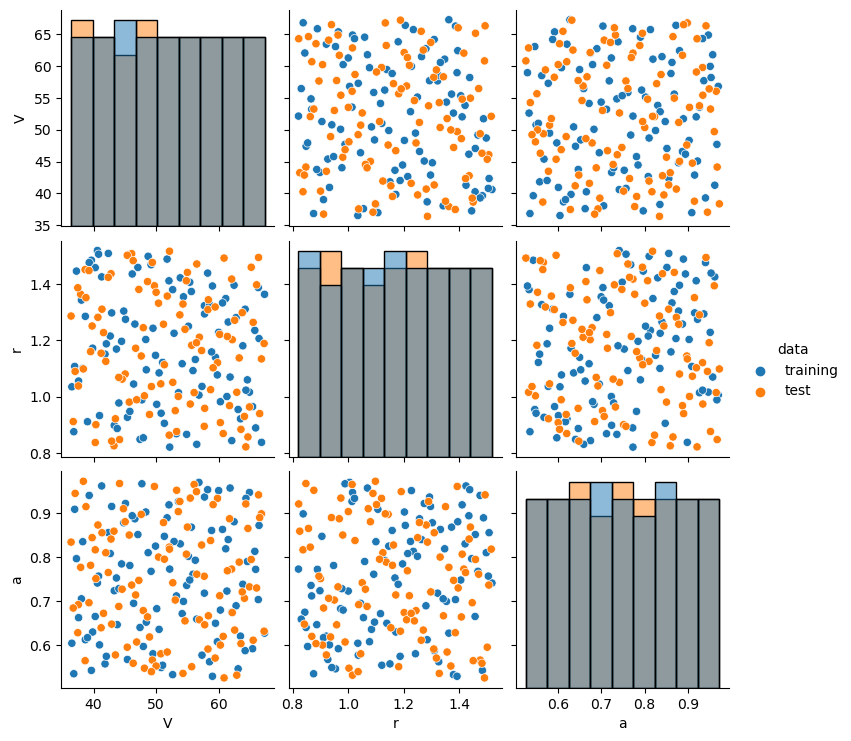

In [18]:
df = pd.DataFrame(theta_tr, columns = ['V','r','a'])
df_test = pd.DataFrame(theta_test, columns = ['V','r','a'])
df['data'] = 'training'
df_test['data'] = 'test'
frames = [df, df_test]
frames = pd.concat(frames)
sns.pairplot(frames, hue='data', diag_kind="hist")

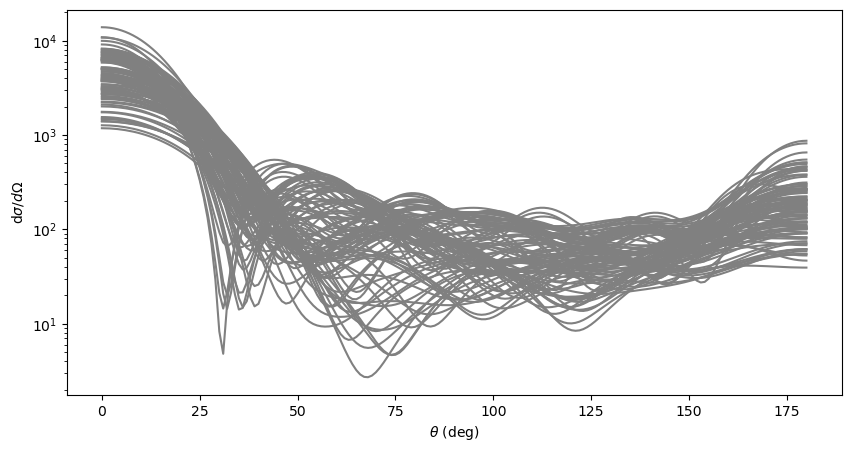

In [19]:
# Observe simulation outcomes
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1)  
for i in range(f_tr.shape[1]):
    ax.plot(x_tr, f_tr[:, i], color='grey', zorder=1)
plt.xlabel(r'$\theta$ (deg)')
plt.ylabel(r'd$\sigma/d\Omega$')
ax.set_yscale('log')
pylab.show()

In [6]:
def generate_input_file_inelastic(parameter_values):
    #os.chdir("bandframework/software/Bfrescox/Tutorial_I/python_scripts")
    file = 'frescox_inputs/12C_n_ine_template.in'

    with open(file) as f:
        content = f.readlines()
        
    no_p = 0;
    for idx, line in enumerate(content):
        if 'XXXXX' in line:
            no_param = line.count('XXXXX')
            line_temp = line
            for i in range(no_param):
                line_temp = line_temp.replace("XXXXX", str(parameter_values[no_p]), 1) 
                no_p += 1
    
            content[idx] = line_temp
    
    f = open("frescox_inputs/frescox_ine_temp_input.in", "a")
    f.writelines(content)
    f.close()   

In [7]:
def frescox_output_inelastic(input_file='frescox_inputs/frescox_ine_temp_input.in',
                   output_file='frescox_outputs/test_temp.out'):

    commands = '''
      cd ~/fewbody/bandframework/software/Bfrescox/Tutorial_I/python_scripts
      mkdir frescox_outputs
      ~/fewbody/Frescoxex/frescox < frescox_inputs/frescox_ine_temp_input.in > frescox_outputs/test_temp.out
    '''

    # Execute frescox
    bashresults = subprocess.run(commands, capture_output=True, shell=True)

    # Read outputs
    #os.chdir("bandframework/software/Bfrescox/Tutorial_I/python_scripts")

    with open(output_file) as f:
        content = f.readlines()
        
    sigma_omega_ratio = [] 
    for idline, line in enumerate(content):
        if ('X-S' in line):
            sigma_omega_ratio.append(float(line.split()[4]))
        
    os.remove(input_file)
    os.remove(output_file)
    
    return sigma_omega_ratio

In [11]:
def frescox_run_inelastic(theta):
    theta_list = theta.tolist()
    f_l = []
    for para_obs in theta_list:
        para_obs += [3.5,1,0.3]
        generate_input_file_inelastic(para_obs)
        exp_output = frescox_output_inelastic()
        f_l.append(exp_output)

    return np.asarray(f_l).T

In [19]:
theta_tr = latin_sampling_3(100)
f_tr_1 = frescox_run_inelastic(theta_tr)
x_tr = np.array(range(362)).reshape((362, 1))

theta_test = latin_sampling_3(100)
f_test_1 = frescox_run_inelastic(theta_test)
x_test = np.array(range(181)).reshape((181, 1))

f_test = f_test_1
f_tr = f_tr_1

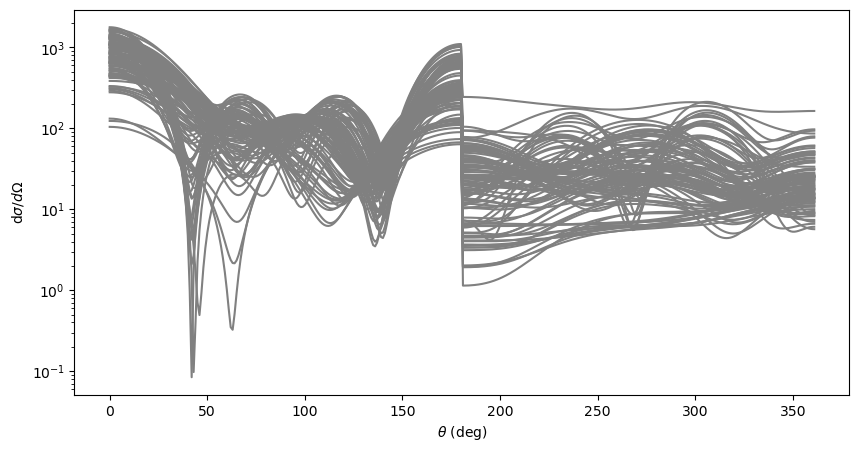

In [20]:
# Observe simulation outcomes
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1)  
for i in range(f_tr.shape[1]):
    ax.plot(x_tr, f_tr[:, i], color='grey', zorder=1)
plt.xlabel(r'$\theta$ (deg)')
plt.ylabel(r'd$\sigma/d\Omega$')
ax.set_yscale('log')
pylab.show()

In [27]:
# def extract_wave_functions(wave_file='fort.17'):
    
#     with open(wave_file) as f:
#         content = f.readlines()
        
#     sigma_omega_ratio = []
    
#     for idline, line in enumerate(content):
#         if ('48.000000' not in line):
#             sigma_omega_ratio.append(line.split())
        
#     print(sigma_omega_ratio)
    
#     return content

In [21]:
def extract_partial_waves(file_extract='fort.17'):
    '''
    this code extracts from the fort.17 file the partial waves and adds them as dictionary with the keys
    corresponding to the different quantum numbers of the coupled set of differential equations. The keys are
    broken down as follows {coupled channel set,channel number,l',j',J, l, j}.
    '''
    # Initialize a dictionary to store the values
    data_dict = {}

    # Initialize a counter for lines starting with "401"
    count_401 = 0

    # Specify the file path
    file_path = 'fort.17'

    # Regular expression pattern to match lines with the desired format
    pattern = re.compile(r'^\s*(\d+\s+\d+\s+\d+\.\d+\s+\d+\.\d+\s+\d+\s+\d+\.\d+)')

    # Open the file and read its contents
    with open(file_path, 'r') as file:
        lines = file.readlines()

    # Initialize a variable to hold the current key
    current_key = None

    # Iterate through the lines to find lines that match the pattern
    for i in range(len(lines)):
        line = lines[i].strip()
        match = pattern.match(line)
        if match:
            # Convert the first 6 values of the line to floats and use them as part of the key
            key_values = match.group(1).split()[:6]
            key_values = [float(value) for value in key_values]
            current_key = tuple([count_401] + key_values)
            # Initialize an empty list for the values associated with the key
            data_dict[current_key] = []
            i += 1  # Move to the next line to start reading values
            while i < len(lines) and not lines[i].startswith("401"):
                # Split the current line into values
                values = lines[i].split()
                # Convert values to floats and append them to the current key's list
                data_dict[current_key].extend([float(value) for value in values])
                i += 1
        elif line.startswith("401"):
            # Increment the counter for lines starting with "401"
            count_401 += 1
        
    for key, values in data_dict.items():
        keys_array.append({key})
        #print(f"Key: {key}")
    
    
    
    return data_dict, keys_array

In [5]:
def wave_functions_format_imaginary(file_extract='fort.17'):
    '''
    This function takes as input the fort.17 file and using the keys from the function extract_partial_waves
    then writes the wavefunction from the fresco output to \psi= real + imag
    '''
    waves_exact = {}
    
    data_dict, keys_array = extract_partial_waves()
    
    for key in keys_array:
        temp_real_array = []
        temp_imag_array = []
        temp_wave = data_dict.get(key)
        for i in range(len(temp_wave)):
            radial = temp_wave[i]
            if (i % 2 != 0):
                temp_imag_array.append(radial)
            if (i % 2 == 0) :
                temp_real_array.append(radial)
                
        waves_exact[key] = np.array(temp_real_array) + 1j* np.array(temp_imag_array)
        
        
    return waves_exact, keys_array